Epoch 0: D Loss: 1.3675, G Loss: 0.6588
Epoch 20: D Loss: 1.3448, G Loss: 0.6777
Epoch 40: D Loss: 1.3185, G Loss: 0.6928
Epoch 60: D Loss: 1.2942, G Loss: 0.7067
Epoch 80: D Loss: 1.2699, G Loss: 0.7173
Epoch 100: D Loss: 1.2412, G Loss: 0.7298
Epoch 120: D Loss: 1.2054, G Loss: 0.7447
Epoch 140: D Loss: 1.1594, G Loss: 0.7641
Epoch 160: D Loss: 1.1037, G Loss: 0.7872
Epoch 180: D Loss: 1.0466, G Loss: 0.8124
Epoch 200: D Loss: 0.9839, G Loss: 0.8450
Epoch 220: D Loss: 0.9198, G Loss: 0.8908
Epoch 240: D Loss: 0.8644, G Loss: 0.9384
Epoch 260: D Loss: 0.8050, G Loss: 1.0029
Epoch 280: D Loss: 0.7484, G Loss: 1.0615
Epoch 300: D Loss: 0.6749, G Loss: 1.1550
Epoch 320: D Loss: 0.6142, G Loss: 1.2419
Epoch 340: D Loss: 0.6470, G Loss: 1.2615
Epoch 360: D Loss: 0.7071, G Loss: 1.3147
Epoch 380: D Loss: 0.6922, G Loss: 1.4502
Epoch 400: D Loss: 0.6466, G Loss: 1.4875
Epoch 420: D Loss: 0.6039, G Loss: 1.4779
Epoch 440: D Loss: 0.5682, G Loss: 1.4922
Epoch 460: D Loss: 0.6023, G Loss: 1.378

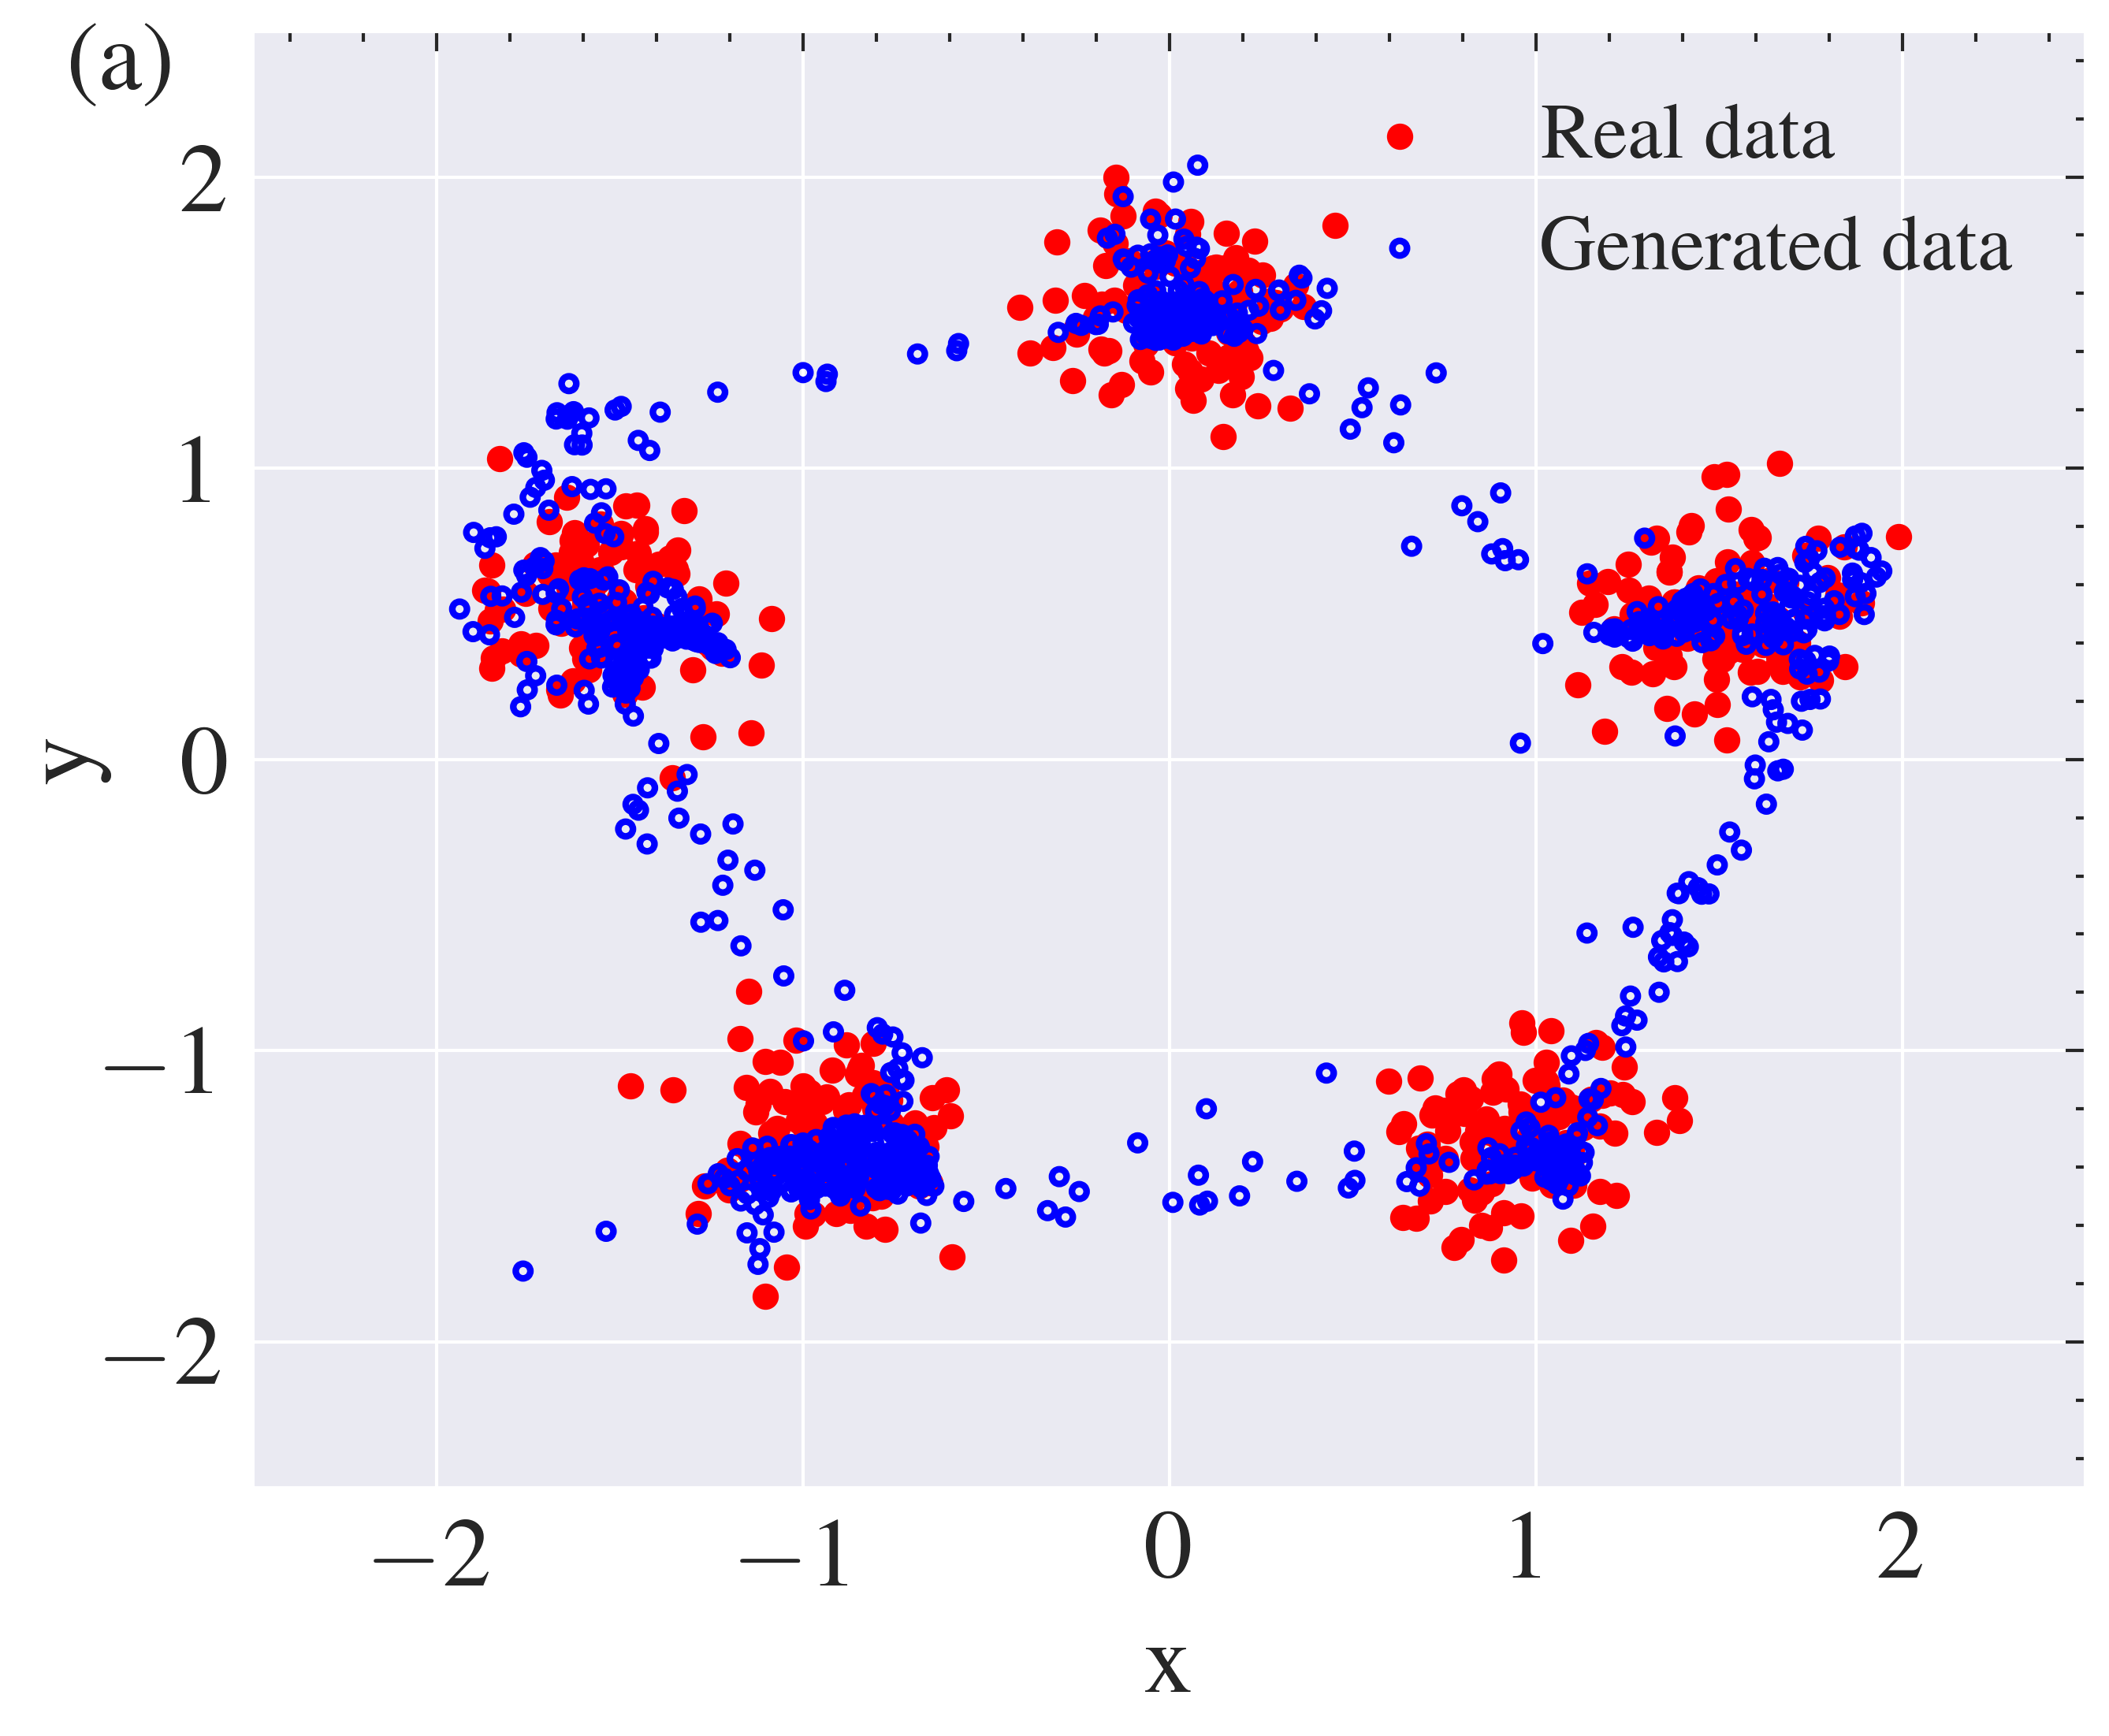

In [2]:
#源代码
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
import scienceplots
# 设置随机数种子
seed = 4321
torch.manual_seed(seed)
np.random.seed(seed)

def genGauss(p, n=1, r=1):
    x = []
    y = []
    for k in range(n):
        x_t, y_t = np.random.multivariate_normal([math.sin(2*k*math.pi/n), math.cos(2*k*math.pi/n)], [[0.0125, 0], [0, 0.0125]], p).T
        x.append(x_t)
        y.append(y_t)

    x = np.array(x).flatten()[:, None]
    y = np.array(y).flatten()[:, None]
    x -= np.mean(x)
    y -= np.mean(y)
    train = np.concatenate((x, y), axis=1)

    return train / (np.max(train) * r)

class Generator(nn.Module):
    def __init__(self, z_dim, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std=0):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, nb_neurons_h1)
        self.fc2 = nn.Linear(nb_neurons_h1, nb_neurons_h2)
        self.fc3 = nn.Linear(nb_neurons_h2, nb_neurons_h3)
        self.fc4 = nn.Linear(nb_neurons_h3, x_dim)

        self.relu = nn.ReLU()
        self.noise_std = noise_std

    def forward(self, z_input):
        # 添加噪声到输入
        z_input = z_input + torch.randn_like(z_input) * self.noise_std
        g_y1 = self.relu(self.fc1(z_input))
        g_y1 = g_y1 + torch.randn_like(g_y1) * self.noise_std  # 添加噪声到隐藏层
        g_y2 = self.relu(self.fc2(g_y1))
        g_y2 = g_y2 + torch.randn_like(g_y2) * self.noise_std  # 添加噪声到隐藏层
        g_y3 = self.relu(self.fc3(g_y2))
        g_y3 = g_y3 + torch.randn_like(g_y3) * self.noise_std  # 添加噪声到隐藏层
        g_y4 = self.fc4(g_y3)
        return g_y4

class Discriminator(nn.Module):
    def __init__(self, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std=0):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, nb_neurons_h1)
        self.fc2 = nn.Linear(nb_neurons_h1, nb_neurons_h2)
        self.fc3 = nn.Linear(nb_neurons_h2, nb_neurons_h3)
        self.fc4 = nn.Linear(nb_neurons_h3, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.noise_std = noise_std

    def forward(self, x_input):
        # 添加噪声到输入
        x_input = x_input + torch.randn_like(x_input) * self.noise_std
        d_y1 = self.relu(self.fc1(x_input))
        d_y1 = d_y1 + torch.randn_like(d_y1) * self.noise_std  # 添加噪声到隐藏层
        d_y2 = self.relu(self.fc2(d_y1))
        d_y2 = d_y2 + torch.randn_like(d_y2) * self.noise_std  # 添加噪声到隐藏层
        d_y3 = self.relu(self.fc3(d_y2))
        d_y3 = d_y3 + torch.randn_like(d_y3) * self.noise_std  # 添加噪声到隐藏层
        d_y4 = self.fc4(d_y3)
        output = self.sigmoid(d_y4)
        return output, d_y4

# 自定义损失函数
def discriminator_loss(d_real, d_fake):
    # 判别器希望 d_real 接近 1，d_fake 接近 0
    d_loss_real = -torch.mean(torch.log(d_real + 1e-8))  # 添加一个小常数避免 log(0)
    d_loss_fake = -torch.mean(torch.log(1 - d_fake + 1e-8))
    return d_loss_real + d_loss_fake

def generator_loss(d_fake):
    # 生成器希望 d_fake 接近 1
    return -torch.mean(torch.log(d_fake + 1e-8))

# 梯度噪声注入函数
def add_gradient_noise(parameters, grad_noise_std):
    for param in parameters:
        if param.grad is not None:
            noise = torch.randn_like(param.grad) * grad_noise_std
            param.grad += noise

# Hyperparameters
nb_neurons_h1 = 16
nb_neurons_h2 = 16
nb_neurons_h3 = 16
learning_rate = 5e-5
batch_size = 32
noise_std = 0.005  # 隐藏层噪声标准差
grad_noise_std = 0.02  # 梯度噪声标准差

z_dim = 2
x_dim = 2
img_dim = 2

# Initialize models
generator = Generator(z_dim, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std)
discriminator = Discriminator(x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

epochs = 5000
X_train = genGauss(100, 5, 0.5)
X_train = torch.Tensor(X_train)
indices = torch.randperm(X_train.size(0))  # 获取打乱后的索引
X_train = X_train[indices]  # 根据新的索引重新排序 X_train

epoch_discriminator_loss = []
epoch_generator_loss = []

# Training loop
for epoch in range(epochs):
    batch_discriminator_loss = []
    batch_generator_loss = []
    nb_batches = int(X_train.shape[0] / batch_size)

    for i in range(nb_batches):
        image_batch = X_train[i * batch_size:(i + 1) * batch_size]

        # Train discriminator
        z_input = torch.randn(batch_size, z_dim)
        fake_img = generator(z_input)

        # Discriminator loss on real images
        d_real, _ = discriminator(image_batch)
        d_fake, _ = discriminator(fake_img.detach())

        # 使用自定义的判别器损失函数
        d_loss = discriminator_loss(d_real, d_fake)

        d_optimizer.zero_grad()
        d_loss.backward()
        add_gradient_noise(discriminator.parameters(), grad_noise_std)  # 梯度噪声注入
        d_optimizer.step()

        # Train generator
        d_fake, _ = discriminator(fake_img)

        # 使用自定义的生成器损失函数
        g_loss = generator_loss(d_fake)

        g_optimizer.zero_grad()
        g_loss.backward()
        add_gradient_noise(generator.parameters(), grad_noise_std)  # 梯度噪声注入
        g_optimizer.step()

        # Track losses
        batch_discriminator_loss.append(d_loss.item())
        batch_generator_loss.append(g_loss.item())

    epoch_discriminator_loss.append(np.mean(batch_discriminator_loss))
    epoch_generator_loss.append(np.mean(batch_generator_loss))

    # Print losses every 20 epochs
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: D Loss: {np.mean(batch_discriminator_loss):.4f}, G Loss: {np.mean(batch_generator_loss):.4f}")

plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science','ieee'])
# 生成 GAN 的输出数据（假设 samples 是 GAN 生成的样本）
samples = generator(torch.randn(1000, z_dim)).detach().numpy()

# 图 (a): 真实数据 vs 生成数据
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
ax.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad=-1)
ax.set_xlim(-2.5, 2.5)  # 设置 x 轴范围
ax.set_ylim(-2.5, 2.5)  # 设置 y 轴范围

# 绘制真实数据（红色星号）
ax.scatter(X_train[:, 0], X_train[:, 1], color="red", label='Real data', marker='.')
# 绘制生成数据（蓝色点）
ax.scatter(samples[:, 0], samples[:, 1], color="blue", label='Generated data', marker='o', facecolors='none', edgecolors='blue',s=5)
ax.legend(loc='upper right', fontsize=12)
ax.text(-3, 2.3, '(a)', fontsize=15)  # 标记 (a)
# fig.savefig('D:/GAN2024/Fig1a.eps', dpi=800)
# 显示图 (a)
plt.show()

In [10]:
#互信息
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
import kde  
import simplebinmi  
from sklearn.cluster import KMeans
import torch
from collections import defaultdict
import os
import pickle
import numpy as np
from sklearn.cluster import MiniBatchKMeans
os.environ["OMP_NUM_THREADS"] = "1"
# 设置随机数种子
seed = 4321
torch.manual_seed(seed)
np.random.seed(seed)

# 创建目录保存激活值
if not os.path.exists('gan_activations'):
    os.makedirs('gan_activations')

# 生成环形高斯分布数据
def genGauss(p, n=1, r=1):
    x = []
    y = []
    for k in range(n):
        x_t, y_t = np.random.multivariate_normal(
            [math.sin(2*k*math.pi/n), math.cos(2*k*math.pi/n)], 
            [[0.0125, 0], [0, 0.0125]], p
        ).T
        x.append(x_t)
        y.append(y_t)
    x = np.array(x).flatten()[:, None]
    y = np.array(y).flatten()[:, None]
    x -= np.mean(x)
    y -= np.mean(y)
    train = np.concatenate((x, y), axis=1)
    train = (train - np.mean(train)) / np.std(train)
    return train / (np.max(train) * r)

# 修改生成器：保存各层激活值
class Generator(nn.Module):
    def __init__(self, z_dim, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std=0):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, nb_neurons_h1)
        self.fc2 = nn.Linear(nb_neurons_h1, nb_neurons_h2)
        self.fc3 = nn.Linear(nb_neurons_h2, nb_neurons_h3)
        self.fc4 = nn.Linear(nb_neurons_h3, x_dim)
        self.relu = nn.ReLU()
        self.noise_std = noise_std

    def forward(self, z_input):
        activations = []
        if isinstance(z_input, tuple):
            x_input = z_input[0]
        z_input = z_input + torch.randn_like(z_input) * self.noise_std
        g_y1 = self.relu(self.fc1(z_input))
        activations.append(g_y1.detach().cpu().numpy())
        g_y1 = g_y1 + torch.randn_like(g_y1) * self.noise_std
        g_y2 = self.relu(self.fc2(g_y1))
        activations.append(g_y2.detach().cpu().numpy())  # 保存第二层激活
        

        g_y2 = g_y2 + torch.randn_like(g_y2) * self.noise_std
        g_y3 = self.relu(self.fc3(g_y2))
        activations.append(g_y3.detach().cpu().numpy())  
        

        # 保存第三层激活
        g_y3 = g_y3 + torch.randn_like(g_y3) * self.noise_std
        g_y4 = self.fc4(g_y3)
        activations.append(g_y4.detach().cpu().numpy())  # 保存输出层激活
        

        return g_y4, activations  # 返回输出和激活值

# 修改判别器：保存各层激活值
class Discriminator(nn.Module):
    def __init__(self, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std=0):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, nb_neurons_h1)
        self.fc2 = nn.Linear(nb_neurons_h1, nb_neurons_h2)
        self.fc3 = nn.Linear(nb_neurons_h2, nb_neurons_h3)
        self.fc4 = nn.Linear(nb_neurons_h3, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.noise_std = noise_std

    def forward(self, x_input):
        activations = []
        if isinstance(x_input, tuple):
            x_input = x_input[0] 
        x_input = x_input + torch.randn_like(x_input) * self.noise_std
        d_y1 = self.relu(self.fc1(x_input))
        activations.append(d_y1.detach().cpu().numpy())  # 保存第一层激活
        

        d_y1 = d_y1 + torch.randn_like(d_y1) * self.noise_std
        d_y2 = self.relu(self.fc2(d_y1))
        activations.append(d_y2.detach().cpu().numpy())  # 保存第二层激活
        

        d_y2 = d_y2 + torch.randn_like(d_y2) * self.noise_std
        d_y3 = self.relu(self.fc3(d_y2))
        activations.append(d_y3.detach().cpu().numpy())  # 保存第三层激活
        

        d_y3 = d_y3 + torch.randn_like(d_y3) * self.noise_std
        d_y4 = self.fc4(d_y3)
        output = self.sigmoid(d_y4)
        activations.append(output.detach().cpu().numpy())  # 保存输出层激活
        

        return output, d_y4, activations  # 返回输出和激活值
# 自定义损失函数
def discriminator_loss(d_real, d_fake):
    # 判别器希望 d_real 接近 1，d_fake 接近 0
    d_loss_real = -torch.mean(torch.log(d_real + 1e-8))  # 添加一个小常数避免 log(0)
    d_loss_fake = -torch.mean(torch.log(1 - d_fake + 1e-8))
    return d_loss_real + d_loss_fake

def generator_loss(d_fake):
    # 生成器希望 d_fake 接近 1
    return -torch.mean(torch.log(d_fake + 1e-8))

# 梯度噪声注入函数
def add_gradient_noise(parameters, grad_noise_std):
    for param in parameters:
        if param.grad is not None:
            noise = torch.randn_like(param.grad) * grad_noise_std
            param.grad += noise

# Hyperparameters
nb_neurons_h1 = 16
nb_neurons_h2 = 16
nb_neurons_h3 = 16
learning_rate = 5e-5
batch_size = 32
noise_std = 0.005  # 隐藏层噪声标准差
grad_noise_std = 0.02  # 梯度噪声标准差

z_dim = 2
x_dim = 2
img_dim = 2

# Initialize models
generator = Generator(z_dim, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std)
discriminator = Discriminator(x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

epochs = 5000
X_train = genGauss(100, 5, 0.5)
X_train = torch.Tensor(X_train)
indices = torch.randperm(X_train.size(0))  # 获取打乱后的索引
X_train = X_train[indices]  # 根据新的索引重新排序 X_train

epoch_discriminator_loss = []
epoch_generator_loss = []



class MI_Plate():
    def __init__(self, n_epochs=5000, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()
        
        self.n_epochs = n_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS

        # 初始化损失存储
        self.epoch_discriminator_loss = []
        self.epoch_generator_loss = []

    def save_activations(self,noise_variance=1e-1):
        self.noise_variance = noise_variance
    
        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x, self.noise_variance)
    
        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x, self.noise_variance)

        nats2bits = 1.0 / np.log(2)  # 以 nats 为单位计算熵，并转换为 bits
         # 初始化存储互信息的数组
       
        MI_XM_upper_all = []  # 存储所有epoch的互信息
        MI_YM_upper_all = []
        
            # 训练循环（修改后）
        for epoch in range(epochs):
            batch_discriminator_loss = []
            batch_generator_loss = []
            nb_batches = int(X_train.shape[0] / batch_size)
            noise_variance=1e-1
        
    
            nats2bits = 1.0 / np.log(2)  # 以 nats 为单位计算熵，并转换为 bits
           
            for i in range(nb_batches):
                image_batch = X_train[i * batch_size:(i + 1) * batch_size]
        
                # 训练判别器
                z_input = torch.randn(batch_size, z_dim)
                fake_img, g_activations = generator(z_input)
        
                # 获取判别器输出和激活值
                d_real, _, d_activations_real = discriminator(image_batch)
                d_fake, _, d_activations_fake = discriminator(fake_img.detach())
        
                # 计算判别器损失
                d_loss = discriminator_loss(d_real, d_fake)
        
                d_optimizer.zero_grad()
                d_loss.backward()
                add_gradient_noise(discriminator.parameters(), grad_noise_std)
                d_optimizer.step()
        
                # 训练生成器
                d_fake, _, d_activations_fake = discriminator(fake_img)
                g_loss = generator_loss(d_fake)
        
                g_optimizer.zero_grad()
                g_loss.backward()
                add_gradient_noise(generator.parameters(), grad_noise_std)
                g_optimizer.step()
        
                # 记录损失
                batch_discriminator_loss.append(d_loss.item())
                batch_generator_loss.append(g_loss.item())
        
            # 计算互信息（仅在特定epoch进行）
            if epoch % 100 == 0:
                MI_XM_upper_epoch = []
                MI_YM_upper_epoch = []
                # 获取真实和生成样本的激活值
                real_images = image_batch
                fake_images = fake_img.detach()
            
                # 获取判别器各层激活值
                _, _, real_activations = discriminator(real_images)
                _, _, fake_activations = discriminator(fake_images)
                # fake_activations = fake_activations.detach()
                fake_activations = [torch.tensor(act).detach() if isinstance(act, np.ndarray) else act.detach() for act in fake_activations]

                # 对激活值进行 detach 处理
                # real_activations = real_activations.detach()
                real_activations = [torch.tensor(act).detach() if isinstance(act, np.ndarray) else act.detach() for act in real_activations]
                
                for layer_idx in range(len(real_activations)):
                    real_act = real_activations[layer_idx].detach().cpu().numpy()
                    fake_act = fake_activations[layer_idx].detach().cpu().numpy()
                        # 真实样本的 Y=1，生成样本的 Y=0
                    pseudo_labels_layer = np.concatenate([
                        np.ones(real_act.shape[0]),  # 真实数据标签 1
                        np.zeros(fake_act.shape[0])  # 生成数据标签 0
                    ])

                    # 合并所有激活值
                    all_activations = np.vstack([real_act, fake_act])  # shape: (2*batch_size, feature_dim)

                    # 计算边际熵 H(M)
                    h_upper = entropy_func_upper(all_activations)

                    # 计算给定 X 的 H(M | X)
                    hM_given_X = kde.kde_condentropy(all_activations, noise_variance)

                    # 计算 H(M | Y)（分别计算 Y=1 和 Y=0）
                    hM_given_Y_upper = 0.0
                    for label in [0, 1]:
                        indices = (pseudo_labels_layer == label)
                        if np.sum(indices) == 0:
                            continue
                        hcond_upper = entropy_func_upper(all_activations[indices, :])
                        hM_given_Y_upper += np.mean(pseudo_labels_layer == label) * hcond_upper

                    # 计算互信息
                    MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                    MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                    # 记录当前层的互信息
                    MI_XM_upper_epoch.append(MI_XM_upper)
                    MI_YM_upper_epoch.append(MI_YM_upper)
                    # 保存当前epoch结果
                MI_XM_upper_all.append(MI_XM_upper_epoch)
                MI_YM_upper_all.append(MI_YM_upper_epoch)
                
                
    
            # 记录epoch损失
            epoch_discriminator_loss.append(np.mean(batch_discriminator_loss))
            epoch_generator_loss.append(np.mean(batch_generator_loss))
    
            # 定期打印和保存
            if epoch % 20 == 0:
                print(f"Epoch {epoch}: D Loss: {np.mean(batch_discriminator_loss):.4f}, G Loss: {np.mean(batch_generator_loss):.4f}")
    
                
            if epoch % 100 == 0:
                save_data = {
                'epoch': epoch,
                'MI_XM': np.mean(MI_XM_upper_epoch),  # 当前epoch均值
                'MI_YM': np.mean(MI_YM_upper_epoch)
                }
                with open(f'gan_activations/epoch_{epoch}.pkl', 'wb') as f:
                    pickle.dump(save_data, f)
        

        MI_XM_upper_array = np.array(MI_XM_upper_all)
        MI_YM_upper_array = np.array(MI_YM_upper_all)
        # 将数据保存为Numpy数组
        np.save('D:/深度学习与信息论/MI_XM_upper_array_KMeans1.npy', MI_XM_upper_array)
        np.save('D:/深度学习与信息论/MI_YM_upper_array_KMeans1.npy', MI_YM_upper_array)
      
     
    
Plate = MI_Plate() #Create class object
Plate.save_activations() #save activations if they weren't saved already
#compute and save MIs if they weren't saved before


Epoch 0: D Loss: 1.3675, G Loss: 0.6588
Epoch 20: D Loss: 1.3447, G Loss: 0.6775
Epoch 40: D Loss: 1.3185, G Loss: 0.6930
Epoch 60: D Loss: 1.2937, G Loss: 0.7062
Epoch 80: D Loss: 1.2693, G Loss: 0.7161
Epoch 100: D Loss: 1.2404, G Loss: 0.7288
Epoch 120: D Loss: 1.2043, G Loss: 0.7446
Epoch 140: D Loss: 1.1586, G Loss: 0.7637
Epoch 160: D Loss: 1.1036, G Loss: 0.7861
Epoch 180: D Loss: 1.0457, G Loss: 0.8116
Epoch 200: D Loss: 0.9851, G Loss: 0.8411
Epoch 220: D Loss: 0.9204, G Loss: 0.8875
Epoch 240: D Loss: 0.8653, G Loss: 0.9337
Epoch 260: D Loss: 0.8052, G Loss: 0.9976
Epoch 280: D Loss: 0.7443, G Loss: 1.0655
Epoch 300: D Loss: 0.6756, G Loss: 1.1479
Epoch 320: D Loss: 0.6130, G Loss: 1.2399
Epoch 340: D Loss: 0.6444, G Loss: 1.2736
Epoch 360: D Loss: 0.7044, G Loss: 1.3257
Epoch 380: D Loss: 0.6931, G Loss: 1.4364
Epoch 400: D Loss: 0.6529, G Loss: 1.4604
Epoch 420: D Loss: 0.6001, G Loss: 1.4787
Epoch 440: D Loss: 0.5854, G Loss: 1.4422
Epoch 460: D Loss: 0.6198, G Loss: 1.347

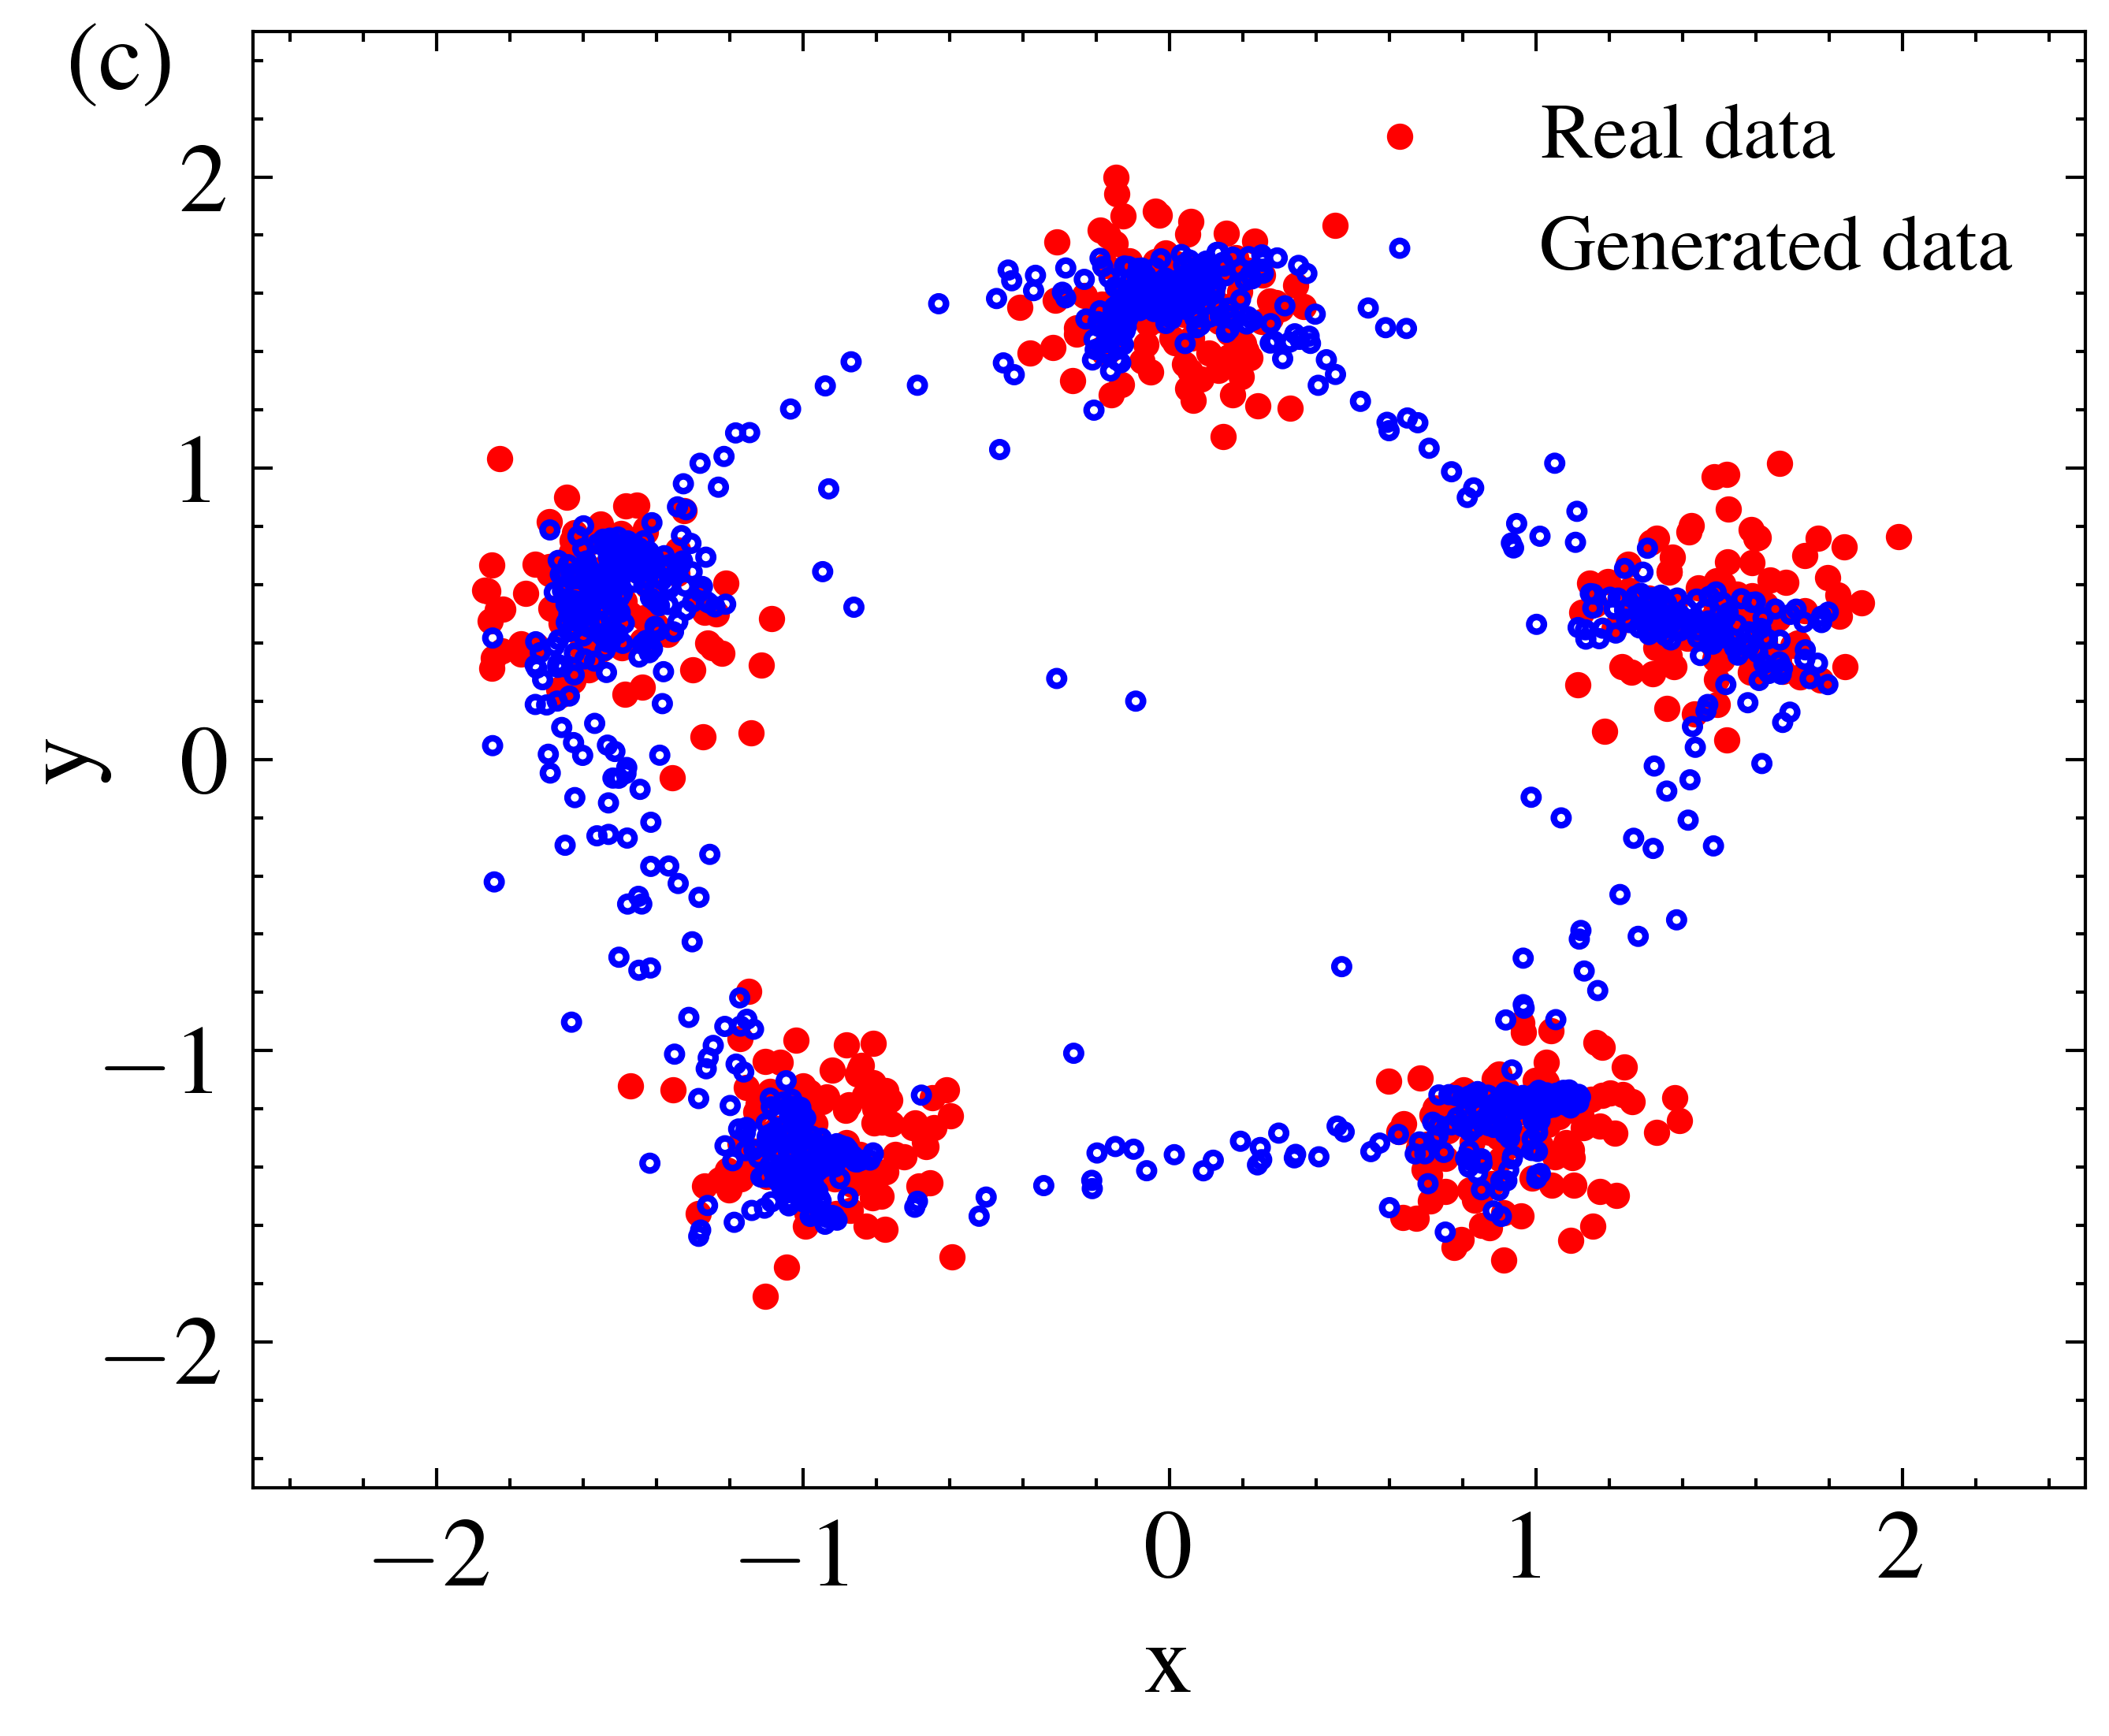

In [12]:
# 生成 GAN 的输出数据（假设 samples 是 GAN 生成的样本）
samples = generator(torch.randn(1000, z_dim))[0].detach().numpy()



# 图 (a): 真实数据 vs 生成数据
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
ax.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad=-1)
ax.set_xlim(-2.5, 2.5)  # 设置 x 轴范围
ax.set_ylim(-2.5, 2.5)  # 设置 y 轴范围

# 绘制真实数据（红色星号）
ax.scatter(X_train[:, 0], X_train[:, 1], color="red", label='Real data', marker='.')
# 绘制生成数据（蓝色点）
ax.scatter(samples[:, 0], samples[:, 1], color="blue", label='Generated data', marker='o', facecolors='none', edgecolors='blue',s=5)
ax.legend(loc='upper right', fontsize=12)
ax.text(-3, 2.3, '(c)', fontsize=15)  # 标记 (a)
fig.savefig('D:/深度学习与信息论/FigGANc.eps', dpi=800)
# 显示图 (a)
plt.show()

In [14]:
import numpy as np

# 加载互信息数据文件
mi_xm = np.load('D:/深度学习与信息论/MI_XM_upper_array_KMeans1.npy')
mi_ym = np.load('D:/深度学习与信息论/MI_YM_upper_array_KMeans1.npy')

print(f"MI_XM shape: {mi_xm.shape}, 包含 {len(mi_xm)} 个值")
print(f"MI_YM shape: {mi_ym.shape}, 包含 {len(mi_ym)} 个值")

print("MI_XM",mi_xm)
print("MI_YM",mi_ym)

MI_XM shape: (50, 4), 包含 50 个值
MI_YM shape: (50, 4), 包含 50 个值
MI_XM [[2.46604921e+00 1.60365425e+00 4.68495489e-01 1.16490036e-03]
 [2.49891269e+00 2.00843984e+00 1.17877730e+00 2.49096851e-02]
 [2.56892752e+00 2.34665920e+00 1.99414774e+00 1.72105680e-01]
 [2.95530460e+00 2.65710440e+00 2.41646386e+00 6.48855304e-01]
 [3.81108305e+00 3.28451706e+00 2.71586846e+00 8.39361411e-01]
 [3.73573899e+00 3.17133011e+00 2.90583224e+00 6.90877008e-01]
 [3.81129751e+00 3.23831787e+00 2.98156618e+00 8.57121328e-01]
 [3.74362870e+00 3.51809323e+00 3.45647271e+00 8.98960795e-01]
 [4.23004792e+00 4.11714690e+00 4.23342910e+00 8.79294579e-01]
 [4.23455541e+00 3.91653335e+00 3.66623358e+00 7.88122878e-01]
 [4.08574097e+00 3.39324621e+00 2.71817389e+00 5.94659465e-01]
 [4.11014161e+00 3.79257204e+00 3.28129135e+00 5.49936924e-01]
 [4.44656874e+00 4.24115060e+00 3.92275052e+00 5.55878323e-01]
 [4.34490619e+00 3.79813877e+00 3.31056624e+00 6.36104919e-01]
 [4.63343546e+00 4.23048604e+00 3.85092059e+00 4.4

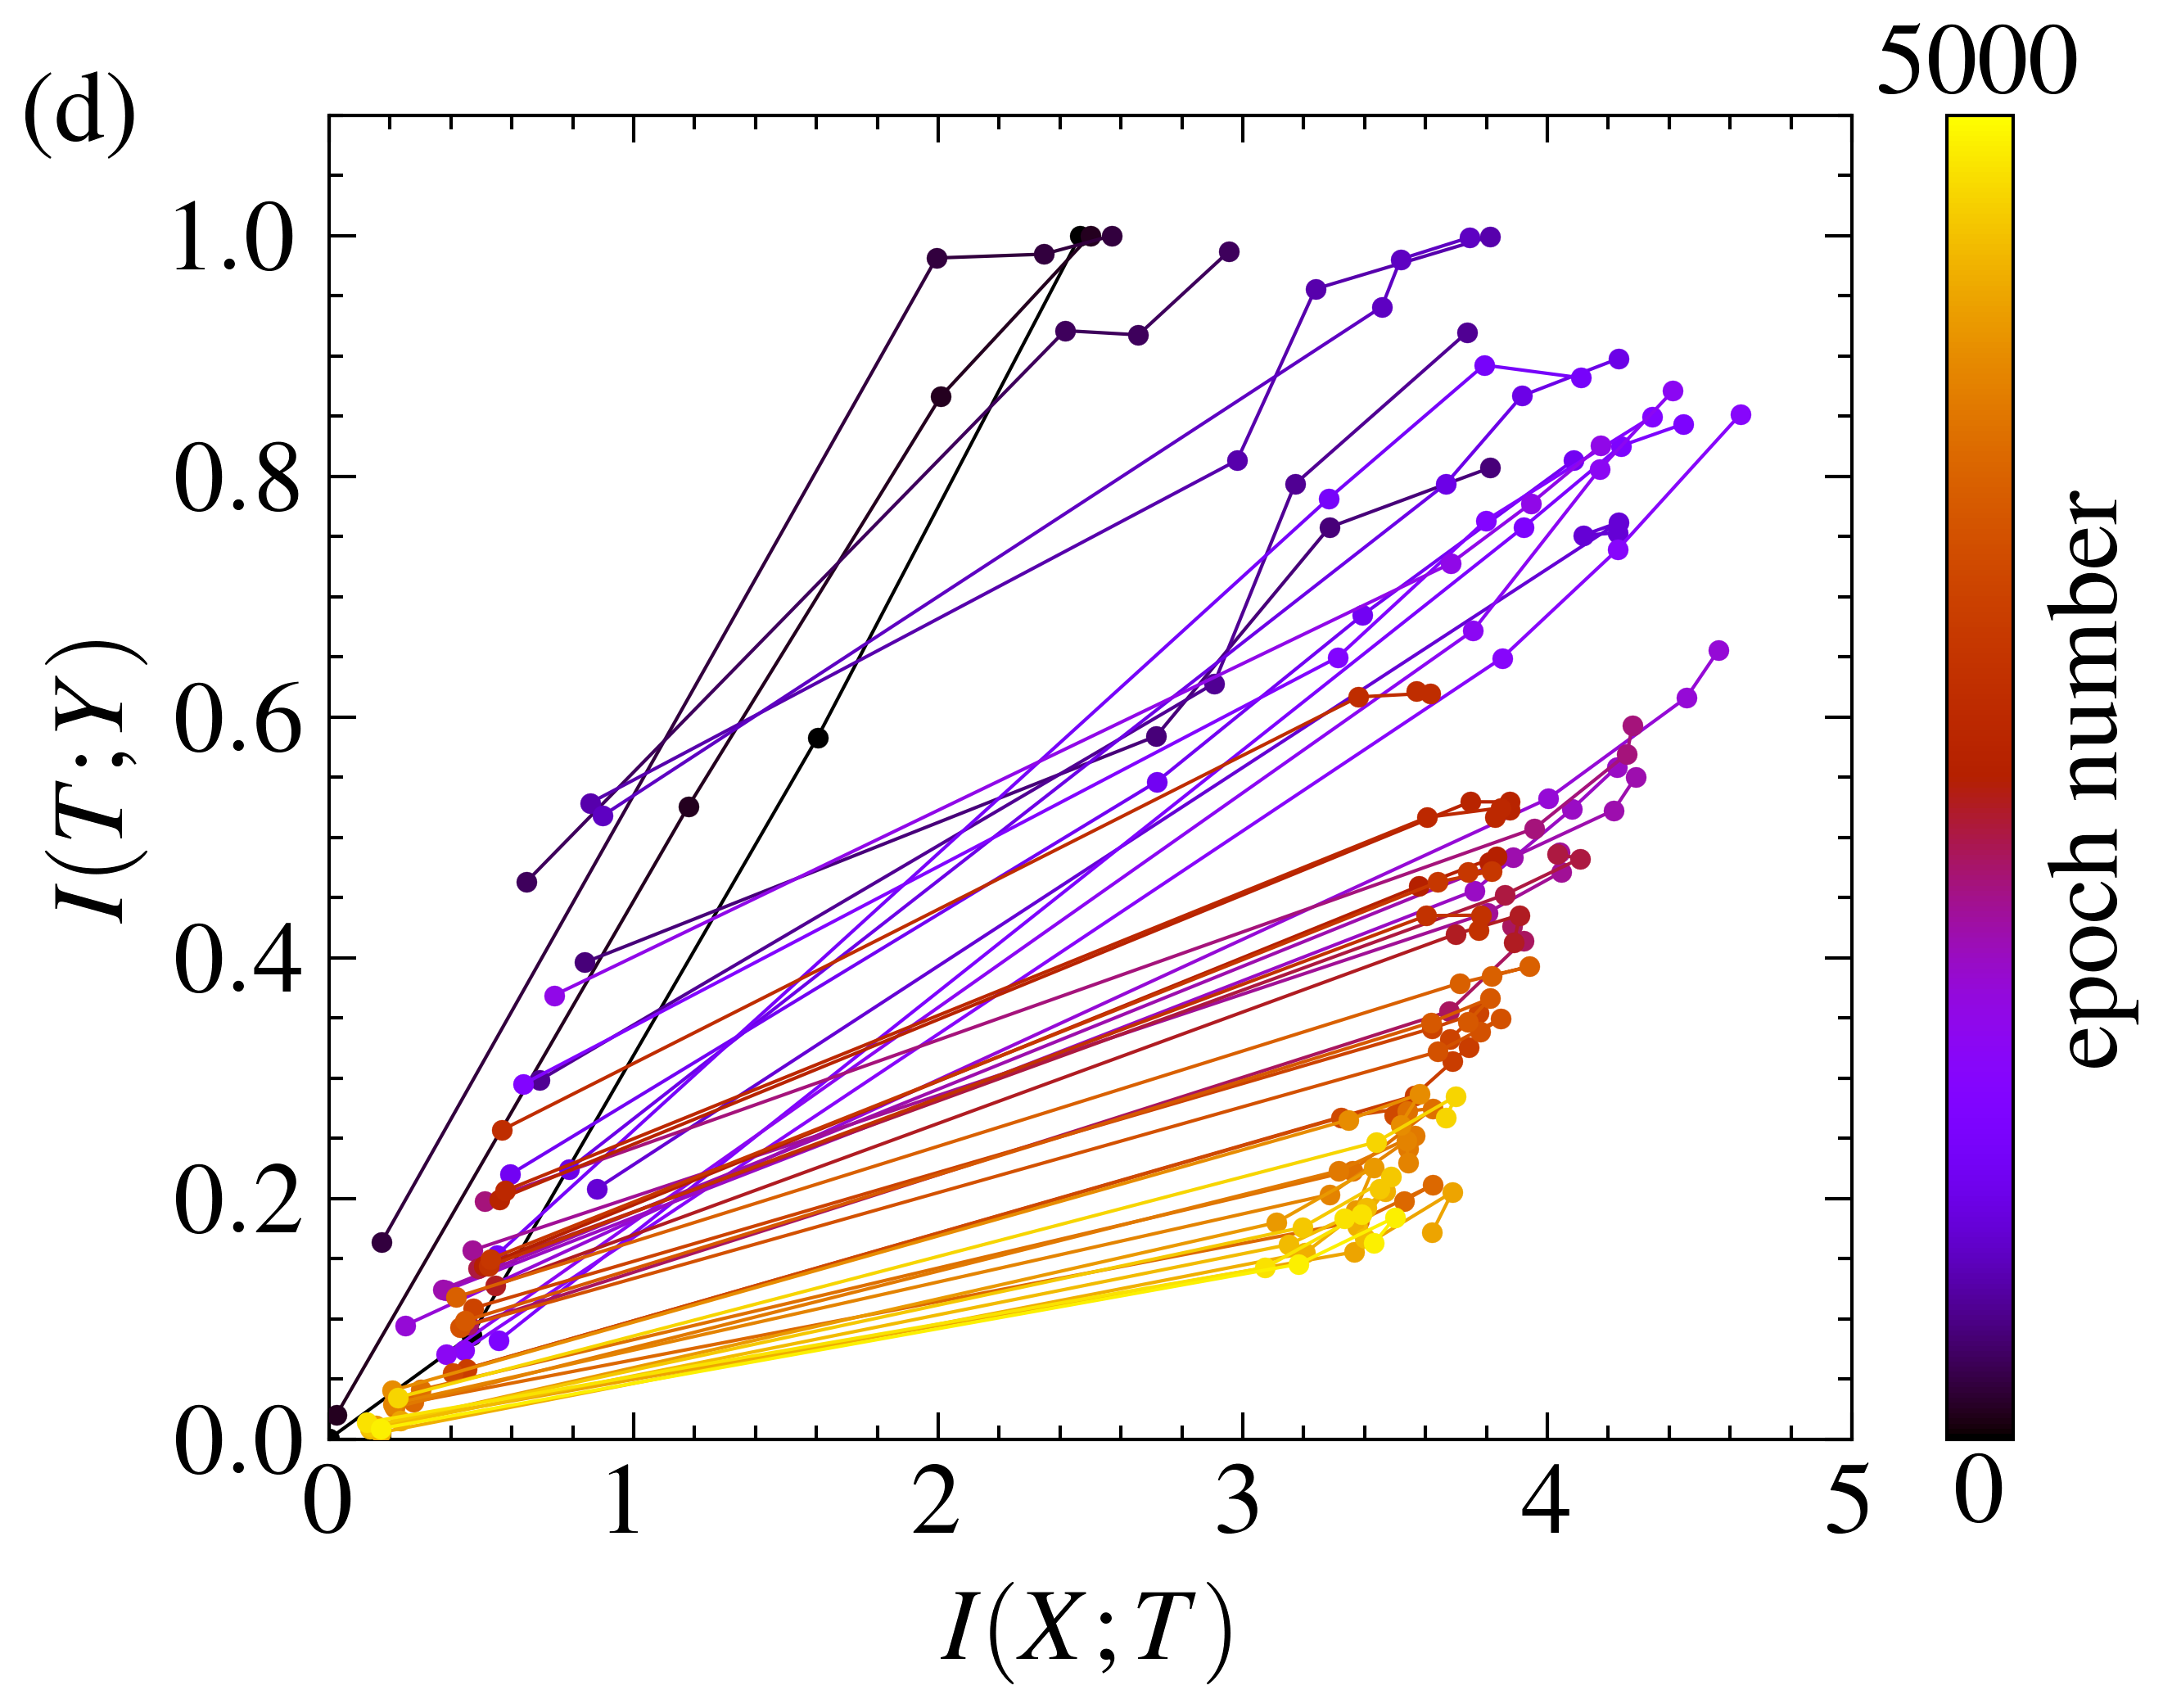

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs=5000):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)
    # 创建白色背景图形（移除了透明设置）
    fig, ax = plt.subplots(figsize=(5, 3.5))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    
    # 设置坐标轴为黑色实线（更细的边框）
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(0.5)  # 更细的边框
        spine.set_linestyle('-')
    # 显式设置所有文字为黑色
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='both', colors='black')
    
   
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)
    ax.grid(False)
     # 设置四个边都显示小刻度
    ax.tick_params(which='both', direction='in', 
                  top=True, bottom=True, left=True, right=True)
    
    # 主刻度设置
    ax.tick_params(which='major', direction='in', 
                  width=0.5, length=4)
    
    # 小刻度设置（四个边都显示）
    ax.minorticks_on()
    ax.tick_params(which='minor', direction='in', 
                  width=0.5, length=2,
                  top=True, bottom=True, left=True, right=True)

   

    cmap = plt.get_cmap('gnuplot')
    actual_epochs = np.arange(0, max_index*100, 100)
    
    for i in range(max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        color = cmap(actual_epochs[i]/num_epochs)
        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=color, zorder=10)

    # 创建颜色条
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_epochs))
    sm._A = []
    
    # 添加颜色条并设置样式
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(0.5)  # 更细的边框
    cbar.set_label('epoch number', fontsize=15, color='black', labelpad=5)
    # cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')
    # 设置坐标轴范围
    ax.set_xticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_ylim(0.0, 1.1)
    ax.set_xlim(0, 5)

    # 添加标注
    ax.text(-0.2, 0.98, '(d)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    # 保存图像
    fig.savefig('D:/深度学习与信息论/FigGANd.eps', dpi=800, transparent=True)
    plt.show()

# 加载数据
IXT_array = np.load('D:/深度学习与信息论/MI_XM_upper_array_KMeans1.npy')
ITY_array = np.load('D:/深度学习与信息论/MI_YM_upper_array_KMeans1.npy')

# 绘制图像
plot_information_plane(IXT_array, ITY_array, num_epochs=5000)

In [23]:
#不加噪声
#互信息
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
import kde  
import simplebinmi  
from sklearn.cluster import KMeans
import torch
from collections import defaultdict
import os
import pickle
import numpy as np
from sklearn.cluster import MiniBatchKMeans
os.environ["OMP_NUM_THREADS"] = "1"
# 设置随机数种子
seed =166 
torch.manual_seed(seed)
np.random.seed(seed)

# 创建目录保存激活值
if not os.path.exists('gan_activations'):
    os.makedirs('gan_activations')

# 生成环形高斯分布数据
def genGauss(p, n=1, r=1):
    x = []
    y = []
    for k in range(n):
        x_t, y_t = np.random.multivariate_normal(
            [math.sin(2*k*math.pi/n), math.cos(2*k*math.pi/n)], 
            [[0.0125, 0], [0, 0.0125]], p
        ).T
        x.append(x_t)
        y.append(y_t)
    x = np.array(x).flatten()[:, None]
    y = np.array(y).flatten()[:, None]
    x -= np.mean(x)
    y -= np.mean(y)
    train = np.concatenate((x, y), axis=1)
    train = (train - np.mean(train)) / np.std(train)
    return train / (np.max(train) * r)

# 修改生成器：保存各层激活值
class Generator(nn.Module):
    def __init__(self, z_dim, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std=0):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, nb_neurons_h1)
        self.fc2 = nn.Linear(nb_neurons_h1, nb_neurons_h2)
        self.fc3 = nn.Linear(nb_neurons_h2, nb_neurons_h3)
        self.fc4 = nn.Linear(nb_neurons_h3, x_dim)
        self.relu = nn.ReLU()
        

    def forward(self, z_input):
        activations = []
        if isinstance(z_input, tuple):
            x_input = z_input[0]
        
        g_y1 = self.relu(self.fc1(z_input))
        activations.append(g_y1.detach().cpu().numpy())
        
        g_y2 = self.relu(self.fc2(g_y1))
        activations.append(g_y2.detach().cpu().numpy())  # 保存第二层激活
        
        g_y3 = self.relu(self.fc3(g_y2))
        activations.append(g_y3.detach().cpu().numpy())  

        # 保存第三层激活
        g_y4 = self.fc4(g_y3)
        activations.append(g_y4.detach().cpu().numpy())  # 保存输出层激活

        return g_y4, activations  # 返回输出和激活值

# 修改判别器：保存各层激活值
class Discriminator(nn.Module):
    def __init__(self, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std=0):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, nb_neurons_h1)
        self.fc2 = nn.Linear(nb_neurons_h1, nb_neurons_h2)
        self.fc3 = nn.Linear(nb_neurons_h2, nb_neurons_h3)
        self.fc4 = nn.Linear(nb_neurons_h3, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x_input):
        activations = []
        if isinstance(x_input, tuple):
            x_input = x_input[0] 
        
        d_y1 = self.relu(self.fc1(x_input))
        activations.append(d_y1.detach().cpu().numpy())  # 保存第一层激活
        
        d_y2 = self.relu(self.fc2(d_y1))
        activations.append(d_y2.detach().cpu().numpy())  # 保存第二层激活
        
        d_y3 = self.relu(self.fc3(d_y2))
        activations.append(d_y3.detach().cpu().numpy())  # 保存第三层激活
       
        d_y4 = self.fc4(d_y3)
        output = self.sigmoid(d_y4)
        activations.append(output.detach().cpu().numpy())  # 保存输出层激活

        return output, d_y4, activations  # 返回输出和激活值
# 自定义损失函数
def discriminator_loss(d_real, d_fake):
    # 判别器希望 d_real 接近 1，d_fake 接近 0
    d_loss_real = -torch.mean(torch.log(d_real + 1e-8))  # 添加一个小常数避免 log(0)
    d_loss_fake = -torch.mean(torch.log(1 - d_fake + 1e-8))
    return d_loss_real + d_loss_fake

def generator_loss(d_fake):
    # 生成器希望 d_fake 接近 1
    return -torch.mean(torch.log(d_fake + 1e-8))

# Hyperparameters
nb_neurons_h1 = 16
nb_neurons_h2 = 16
nb_neurons_h3 = 16
learning_rate = 5e-5
batch_size = 32
noise_std = 0.005  # 隐藏层噪声标准差
grad_noise_std = 0.02  # 梯度噪声标准差

z_dim = 2
x_dim = 2
img_dim = 2

# Initialize models
generator = Generator(z_dim, x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std)
discriminator = Discriminator(x_dim, nb_neurons_h1, nb_neurons_h2, nb_neurons_h3, noise_std)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

epochs = 5000
X_train = genGauss(100, 5, 0.5)
X_train = torch.Tensor(X_train)
indices = torch.randperm(X_train.size(0))  # 获取打乱后的索引
X_train = X_train[indices]  # 根据新的索引重新排序 X_train

epoch_discriminator_loss = []
epoch_generator_loss = []



class MI_Plate():
    def __init__(self, n_epochs=5000, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()
        
        self.n_epochs = n_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS

        # 初始化损失存储
        self.epoch_discriminator_loss = []
        self.epoch_generator_loss = []

    def save_activations(self,noise_variance=1e-1):
        self.noise_variance = noise_variance
    
        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x, self.noise_variance)
    
        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x, self.noise_variance)

        nats2bits = 1.0 / np.log(2)  # 以 nats 为单位计算熵，并转换为 bits
         # 初始化存储互信息的数组
       
        MI_XM_upper_all = []  # 存储所有epoch的互信息
        MI_YM_upper_all = []
        
            # 训练循环（修改后）
        for epoch in range(epochs):
            batch_discriminator_loss = []
            batch_generator_loss = []
            nb_batches = int(X_train.shape[0] / batch_size)
            
            nats2bits = 1.0 / np.log(2)  # 以 nats 为单位计算熵，并转换为 bits
           
            for i in range(nb_batches):
                image_batch = X_train[i * batch_size:(i + 1) * batch_size]
        
                # 训练判别器
                z_input = torch.randn(batch_size, z_dim)
                fake_img, g_activations = generator(z_input)
        
                # 获取判别器输出和激活值
                d_real, _, d_activations_real = discriminator(image_batch)
                d_fake, _, d_activations_fake = discriminator(fake_img.detach())
        
                # 计算判别器损失
                d_loss = discriminator_loss(d_real, d_fake)
        
                d_optimizer.zero_grad()
                d_loss.backward()
                
                d_optimizer.step()
        
                # 训练生成器
                d_fake, _, d_activations_fake = discriminator(fake_img)
                g_loss = generator_loss(d_fake)
        
                g_optimizer.zero_grad()
                g_loss.backward()               
                g_optimizer.step()
        
                # 记录损失
                batch_discriminator_loss.append(d_loss.item())
                batch_generator_loss.append(g_loss.item())
            epoch_discriminator_loss.append(np.mean(batch_discriminator_loss))
            epoch_generator_loss.append(np.mean(batch_generator_loss))
        
        
            # 计算互信息（仅在特定epoch进行）
            if epoch % 100 == 0:
                MI_XM_upper_epoch = []
                MI_YM_upper_epoch = []
                # 获取真实和生成样本的激活值
                real_images = image_batch
                fake_images = fake_img.detach()
            
                # 获取判别器各层激活值
                _, _, real_activations = discriminator(real_images)
                _, _, fake_activations = discriminator(fake_images)
                # fake_activations = fake_activations.detach()
                fake_activations = [torch.tensor(act).detach() if isinstance(act, np.ndarray) else act.detach() for act in fake_activations]

                # 对激活值进行 detach 处理
                # real_activations = real_activations.detach()
                real_activations = [torch.tensor(act).detach() if isinstance(act, np.ndarray) else act.detach() for act in real_activations]
                
                for layer_idx in range(len(real_activations)):
                    real_act = real_activations[layer_idx].detach().cpu().numpy()
                    fake_act = fake_activations[layer_idx].detach().cpu().numpy()
                        # 真实样本的 Y=1，生成样本的 Y=0
                    pseudo_labels_layer = np.concatenate([
                        np.ones(real_act.shape[0]),  # 真实数据标签 1
                        np.zeros(fake_act.shape[0])  # 生成数据标签 0
                    ])

                    # 合并所有激活值
                    all_activations = np.vstack([real_act, fake_act])  # shape: (2*batch_size, feature_dim)

                    # 计算边际熵 H(M)
                    h_upper = entropy_func_upper(all_activations)

                    # 计算给定 X 的 H(M | X)
                    hM_given_X = kde.kde_condentropy(all_activations, noise_variance)

                    # 计算 H(M | Y)（分别计算 Y=1 和 Y=0）
                    hM_given_Y_upper = 0.0
                    for label in [0, 1]:
                        indices = (pseudo_labels_layer == label)
                        if np.sum(indices) == 0:
                            continue
                        hcond_upper = entropy_func_upper(all_activations[indices, :])
                        hM_given_Y_upper += np.mean(pseudo_labels_layer == label) * hcond_upper

                    # 计算互信息
                    MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                    MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                    # 记录当前层的互信息
                    MI_XM_upper_epoch.append(MI_XM_upper)
                    MI_YM_upper_epoch.append(MI_YM_upper)
                    # 保存当前epoch结果
                MI_XM_upper_all.append(MI_XM_upper_epoch)
                MI_YM_upper_all.append(MI_YM_upper_epoch)
                
                
            # 记录epoch损失
            epoch_discriminator_loss.append(np.mean(batch_discriminator_loss))
            epoch_generator_loss.append(np.mean(batch_generator_loss))
    
            # 定期打印和保存
            if epoch % 50 == 0:
                print(f"Epoch {epoch}: D Loss: {np.mean(batch_discriminator_loss):.4f}, G Loss: {np.mean(batch_generator_loss):.4f}")
    
                
            if epoch % 100 == 0:
                save_data = {
                'epoch': epoch,
                'MI_XM': np.mean(MI_XM_upper_epoch),  # 当前epoch均值
                'MI_YM': np.mean(MI_YM_upper_epoch)
                }
                with open(f'gan_activations/epoch_{epoch}.pkl3', 'wb') as f:
                    pickle.dump(save_data, f)
        

        MI_XM_upper_array = np.array(MI_XM_upper_all)
        MI_YM_upper_array = np.array(MI_YM_upper_all)
        # 将数据保存为Numpy数组
        np.save('D:/深度学习与信息论/MI_XM_upper_array_KMeans3.npy', MI_XM_upper_array)
        np.save('D:/深度学习与信息论/MI_YM_upper_array_KMeans3.npy', MI_YM_upper_array)
      
     
    
Plate = MI_Plate() #Create class object
Plate.save_activations() #save activations if they weren't saved already
#compute and save MIs if they weren't saved before



Epoch 0: D Loss: 1.4032, G Loss: 0.8447
Epoch 50: D Loss: 1.2998, G Loss: 0.7850
Epoch 100: D Loss: 1.0748, G Loss: 0.9954
Epoch 150: D Loss: 0.9363, G Loss: 1.0232
Epoch 200: D Loss: 1.2296, G Loss: 0.8359
Epoch 250: D Loss: 0.7515, G Loss: 1.3835
Epoch 300: D Loss: 1.3046, G Loss: 0.6505
Epoch 350: D Loss: 1.4962, G Loss: 0.7870
Epoch 400: D Loss: 1.0122, G Loss: 1.2007
Epoch 450: D Loss: 1.0557, G Loss: 1.3651
Epoch 500: D Loss: 0.9331, G Loss: 1.2472
Epoch 550: D Loss: 1.0676, G Loss: 1.0467
Epoch 600: D Loss: 2.1475, G Loss: 0.4720
Epoch 650: D Loss: 1.2042, G Loss: 1.1288
Epoch 700: D Loss: 0.9869, G Loss: 1.0244
Epoch 750: D Loss: 0.9564, G Loss: 1.0785
Epoch 800: D Loss: 1.4816, G Loss: 0.5713
Epoch 850: D Loss: 1.2981, G Loss: 0.9563
Epoch 900: D Loss: 1.2297, G Loss: 1.2215
Epoch 950: D Loss: 1.0514, G Loss: 0.9629
Epoch 1000: D Loss: 0.8034, G Loss: 1.0844
Epoch 1050: D Loss: 0.9536, G Loss: 1.1822
Epoch 1100: D Loss: 1.7410, G Loss: 0.5314
Epoch 1150: D Loss: 0.8527, G Loss

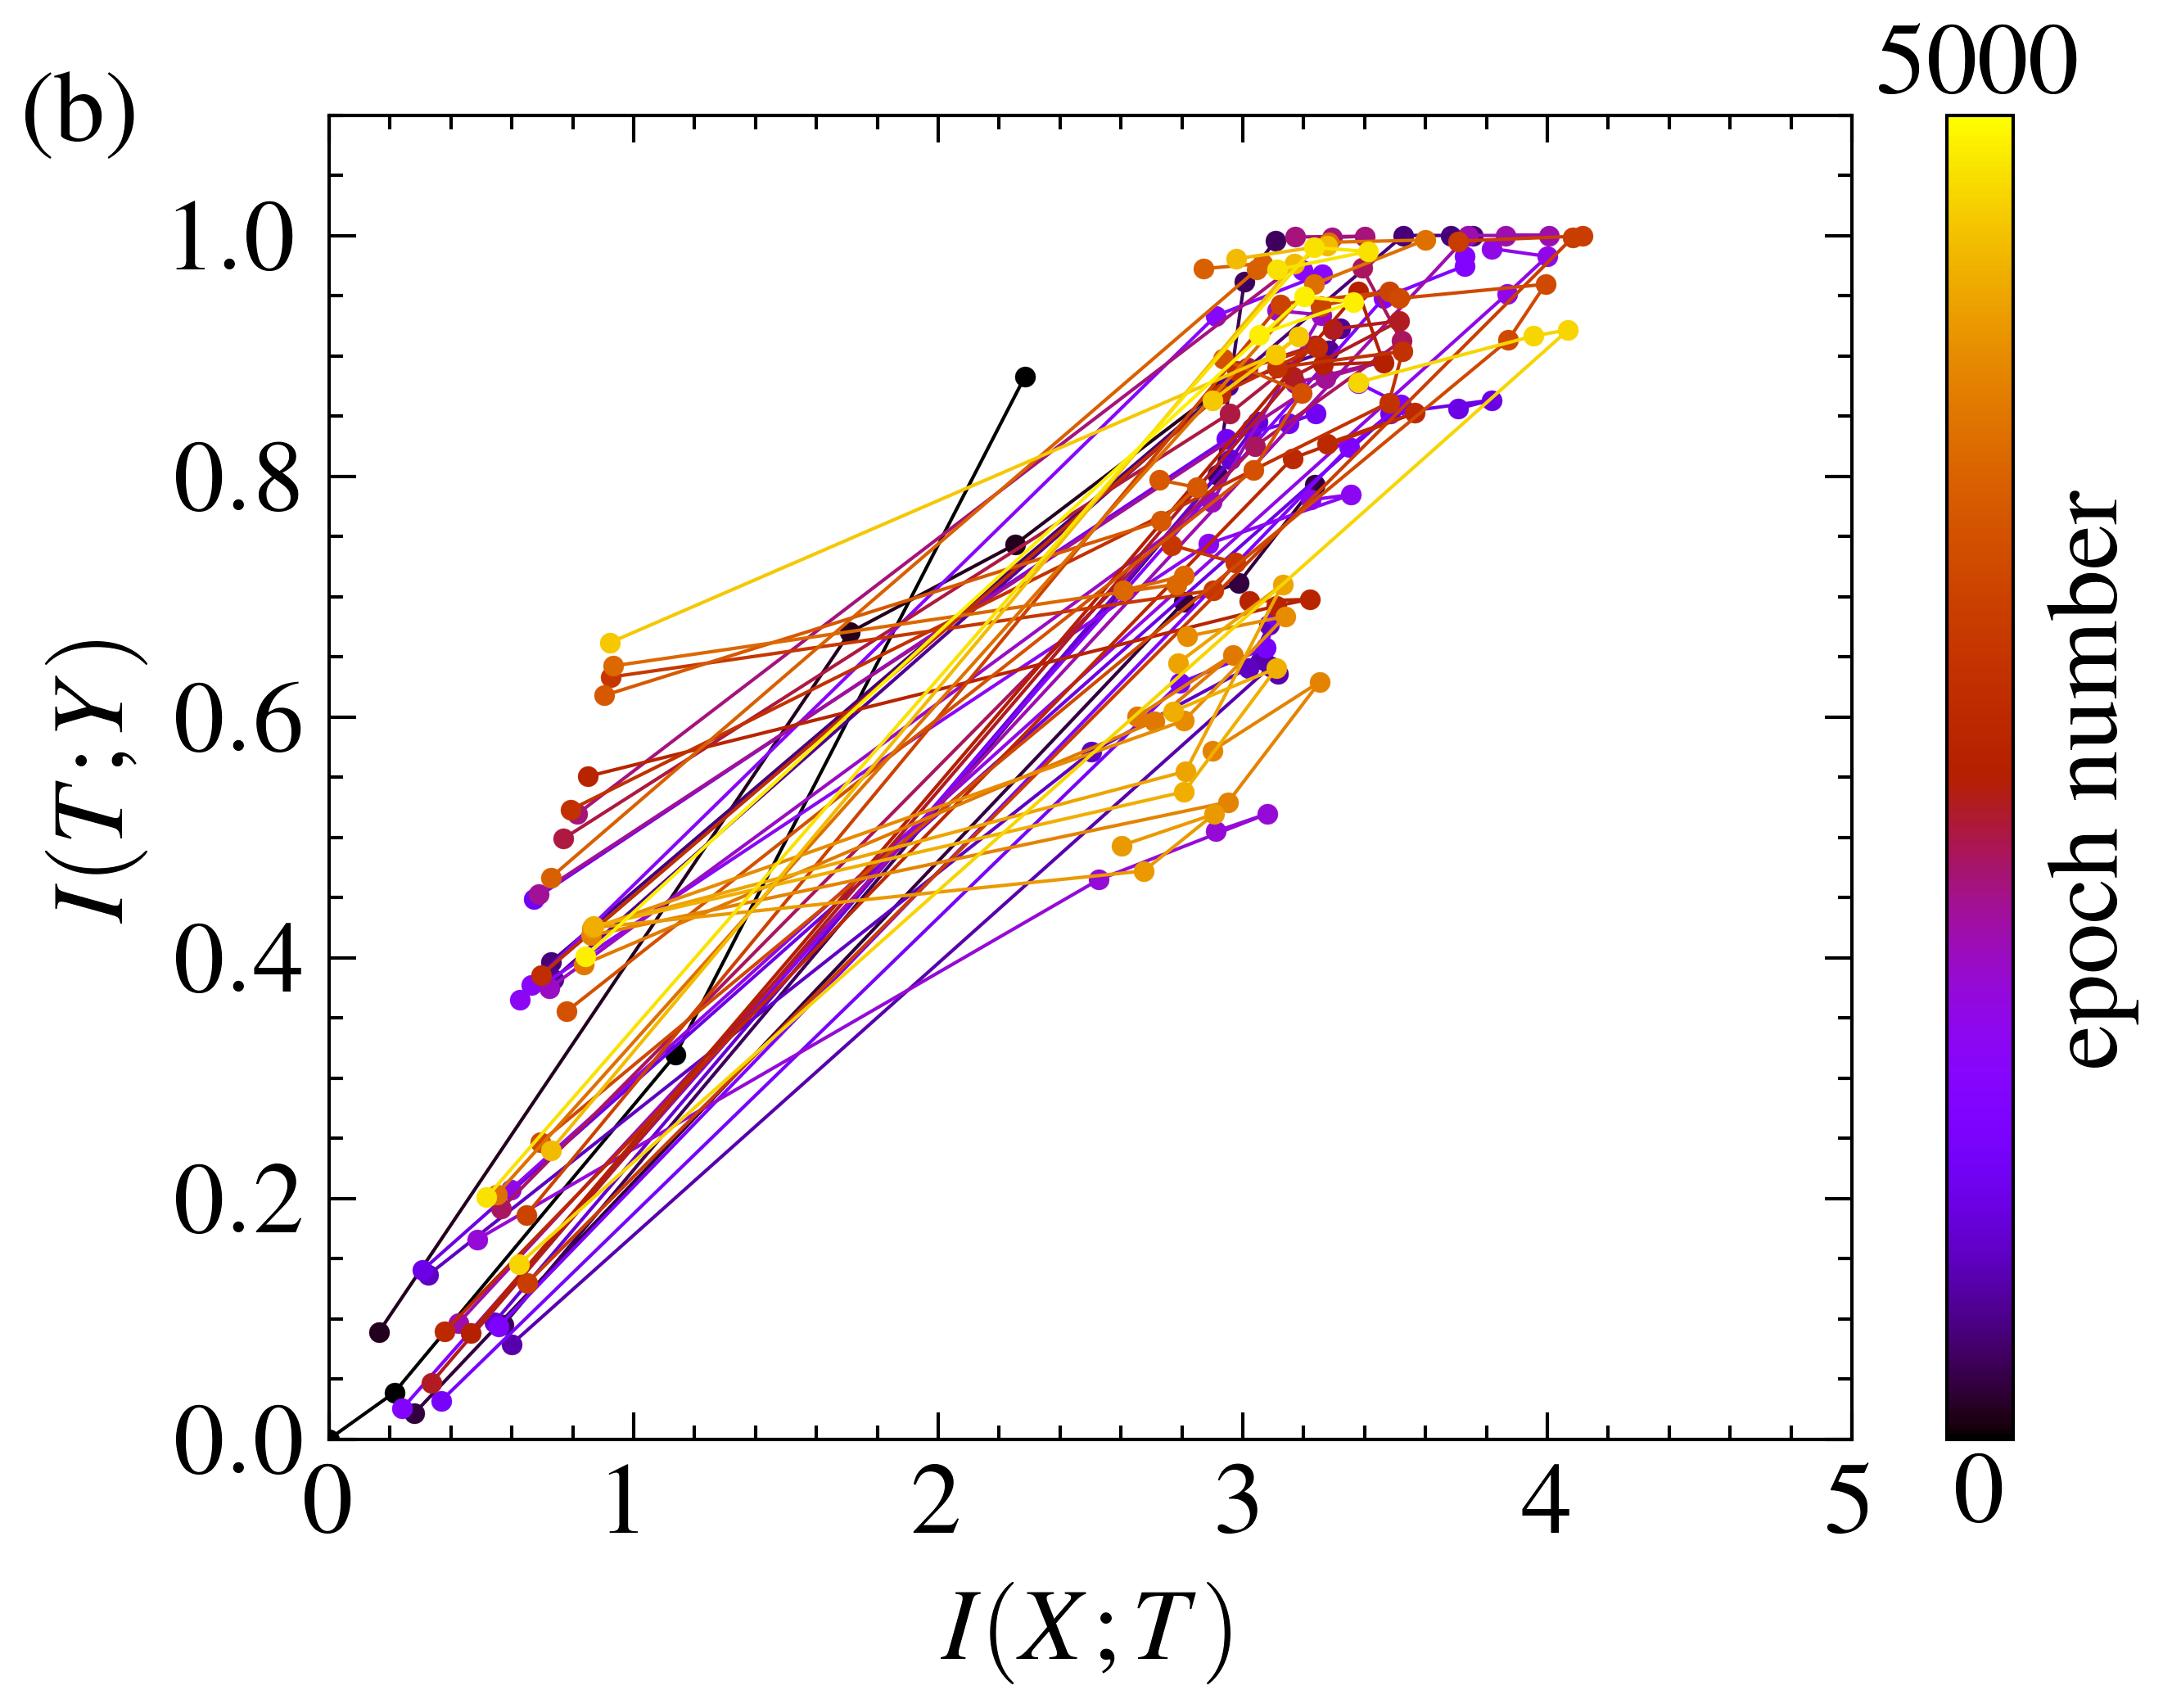

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs=5000):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)
    # 创建白色背景图形（移除了透明设置）
    fig, ax = plt.subplots(figsize=(5, 3.5))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    
    # 设置坐标轴为黑色实线（更细的边框）
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(0.5)  # 更细的边框
        spine.set_linestyle('-')
    # 显式设置所有文字为黑色
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='both', colors='black')
    
   
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)
    ax.grid(False)
     # 设置四个边都显示小刻度
    ax.tick_params(which='both', direction='in', 
                  top=True, bottom=True, left=True, right=True)
    
    # 主刻度设置
    ax.tick_params(which='major', direction='in', 
                  width=0.5, length=4)
    
    # 小刻度设置（四个边都显示）
    ax.minorticks_on()
    ax.tick_params(which='minor', direction='in', 
                  width=0.5, length=2,
                  top=True, bottom=True, left=True, right=True)

   

    cmap = plt.get_cmap('gnuplot')
    actual_epochs = np.arange(0, max_index*100, 100)
    
    for i in range(max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        color = cmap(actual_epochs[i]/num_epochs)
        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=color, zorder=10)

    # 创建颜色条
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_epochs))
    sm._A = []
    
    # 添加颜色条并设置样式
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(0.5)  # 更细的边框
    cbar.set_label('epoch number', fontsize=15, color='black', labelpad=5)
    # cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')
    # 设置坐标轴范围
    ax.set_xticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_ylim(0.0, 1.1)
    ax.set_xlim(0, 5)

    # 添加标注
    ax.text(-0.2, 0.98, '(b)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    # 保存图像
    fig.savefig('D:/深度学习与信息论/FigGANb.eps', dpi=800, transparent=True)
    plt.show()

# 加载数据
IXT_array = np.load('D:/深度学习与信息论/MI_XM_upper_array_KMeans3.npy')
ITY_array = np.load('D:/深度学习与信息论/MI_YM_upper_array_KMeans3.npy')

# 绘制图像
plot_information_plane(IXT_array, ITY_array, num_epochs=5000)

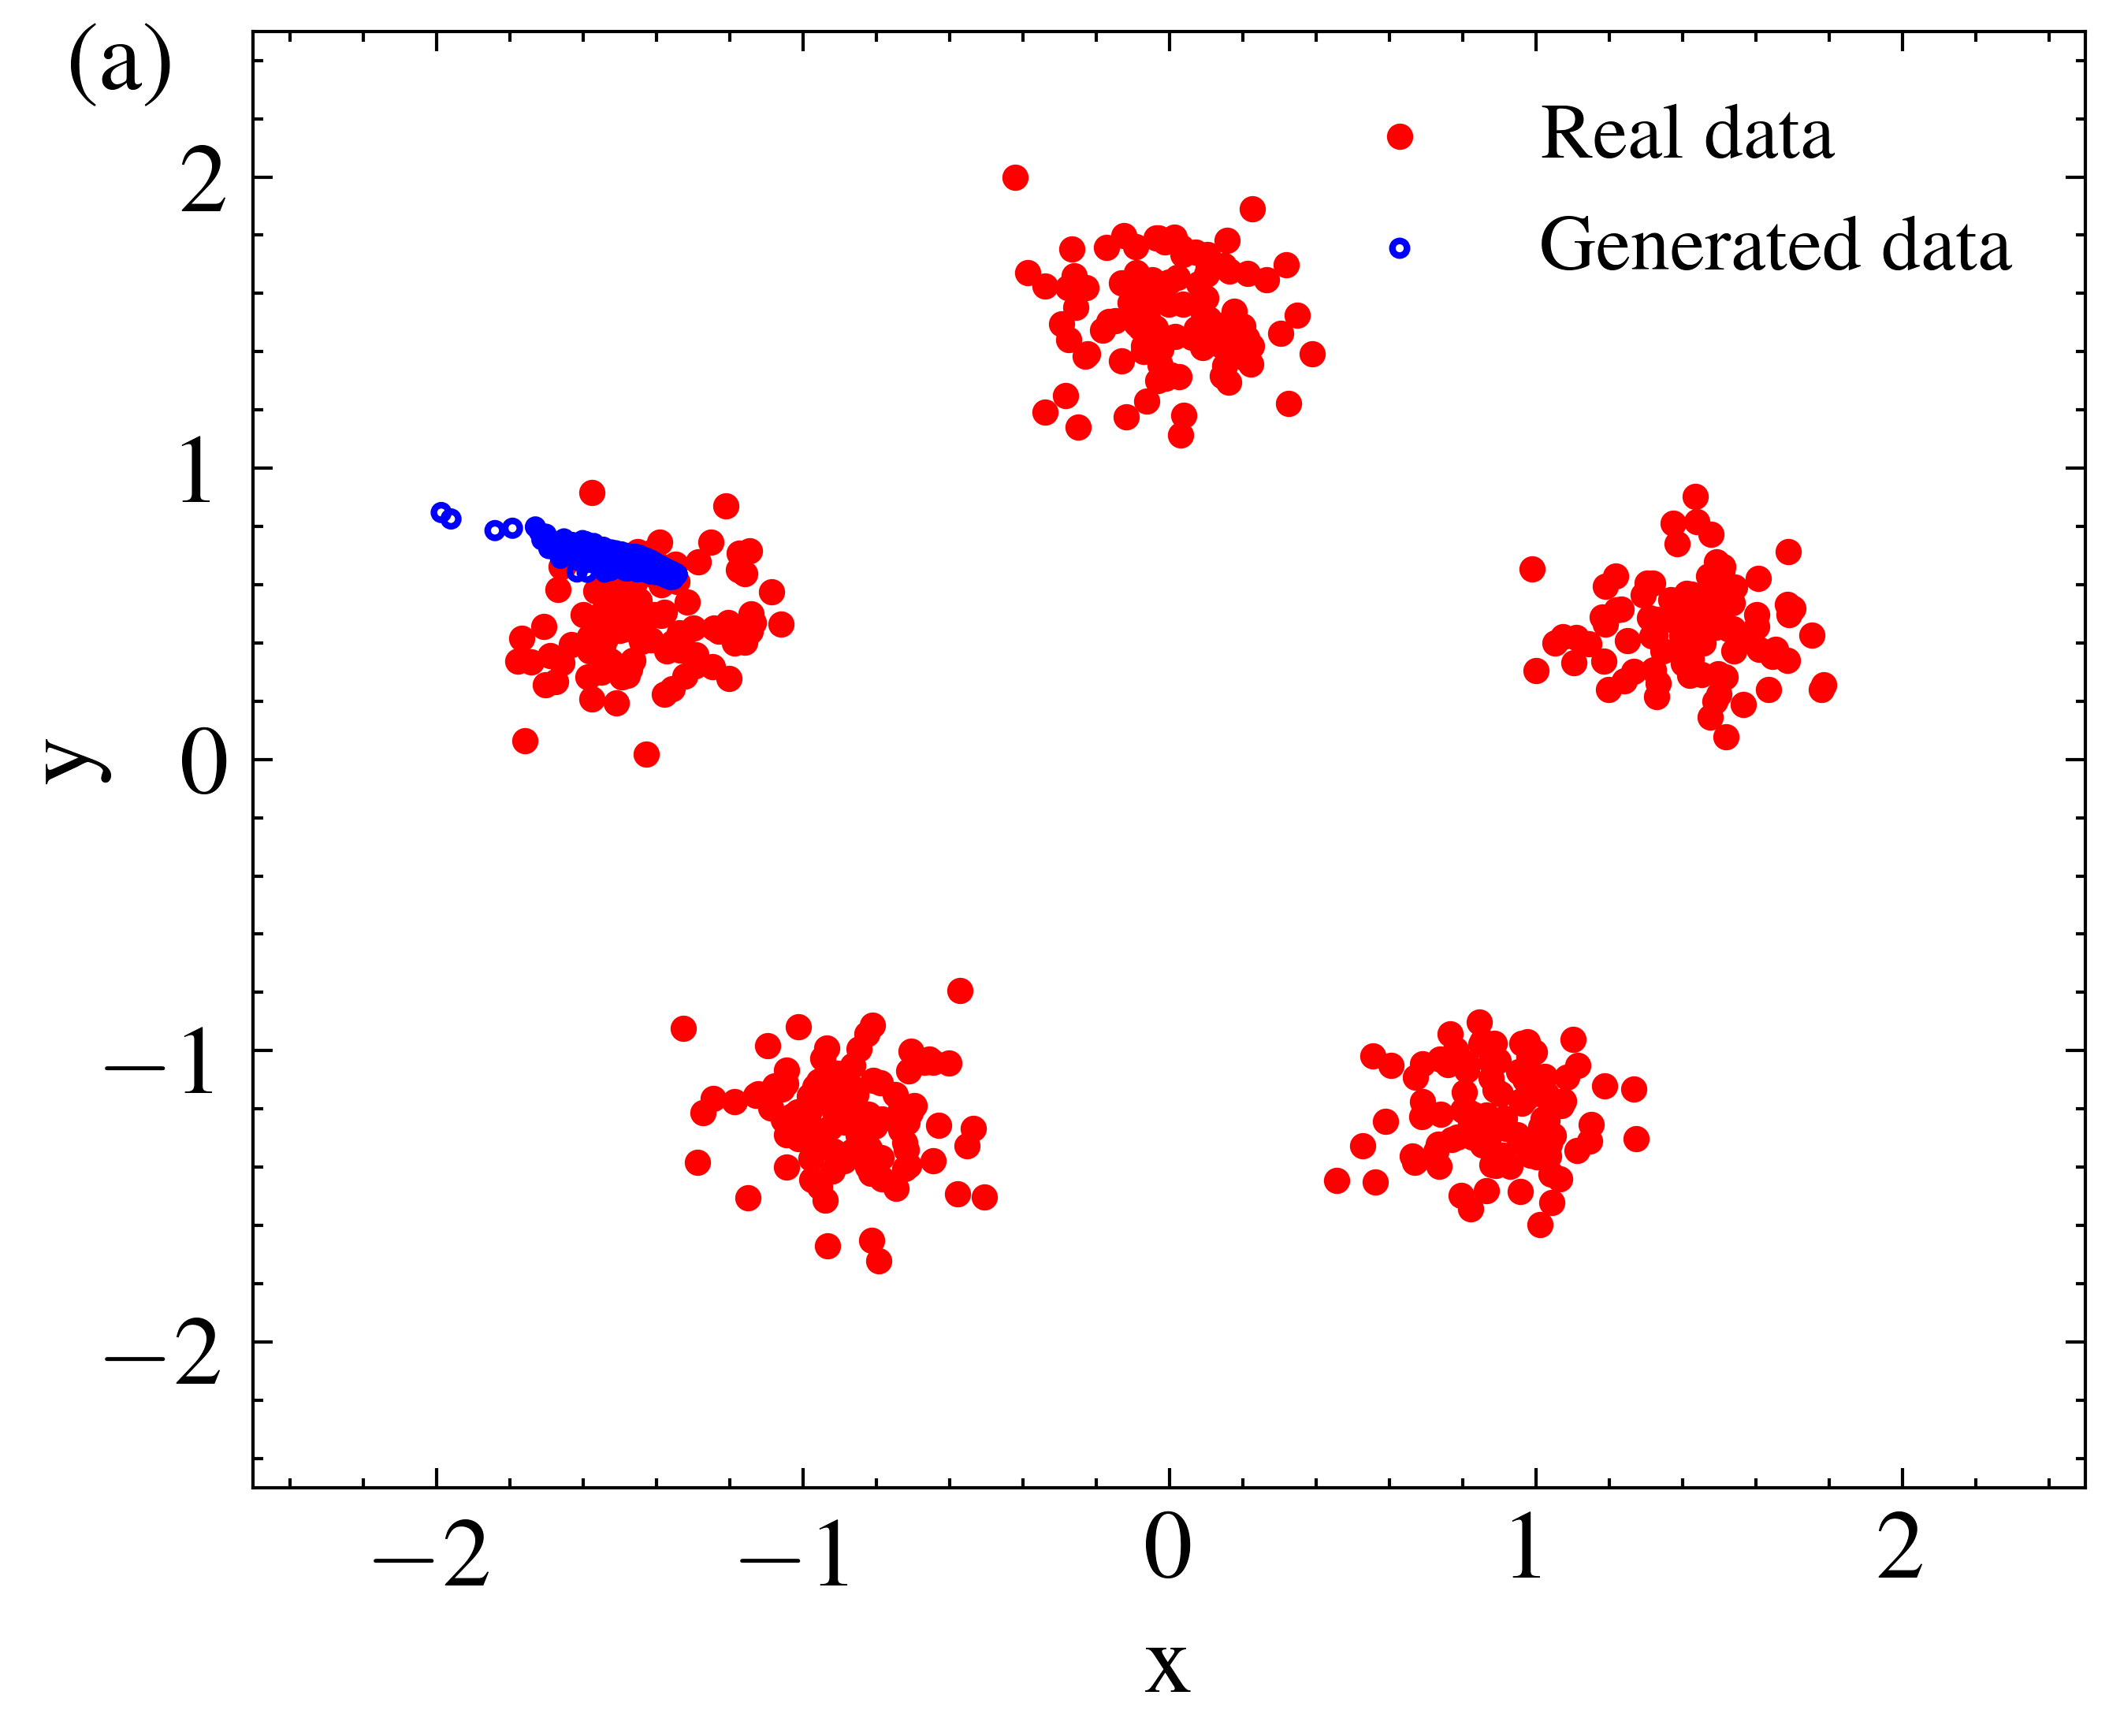

In [24]:
# 生成 GAN 的输出数据（假设 samples 是 GAN 生成的样本）
samples = generator(torch.randn(1000, z_dim))[0].detach().numpy()



# 图 (a): 真实数据 vs 生成数据
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
ax.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad=-1)
ax.set_xlim(-2.5, 2.5)  # 设置 x 轴范围
ax.set_ylim(-2.5, 2.5)  # 设置 y 轴范围

# 绘制真实数据（红色星号）
ax.scatter(X_train[:, 0], X_train[:, 1], color="red", label='Real data', marker='.')
# 绘制生成数据（蓝色点）
ax.scatter(samples[:, 0], samples[:, 1], color="blue", label='Generated data', marker='o', facecolors='none', edgecolors='blue',s=5)
ax.legend(loc='upper right', fontsize=12)
ax.text(-3, 2.3, '(a)', fontsize=15)  # 标记 (a)
fig.savefig('D:/深度学习与信息论/FigGANa.eps', dpi=800)
# 显示图 (a)
plt.show()